
# Time Series: Predict Demand

## The Data

Data is about passenger traffic of company SeaAirport. SearAirport operated Sea Planes across USA. Fields are: <br>
Month: Month in which traffic data was recorded <br>
'#Passenger': No of travellers availing Service in that month
____


## Getting Started

Let's import some libraries we will need:

In [ ]:
# Import Packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

#importing packages for the prediction of time-series data
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

Read the data using pandas in DataFrame df

In [66]:
df = pd.read_csv('SeaPlaneTravel.csv', index_col='Month',parse_dates=['Month'])
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')

Let's take a quick look at the data.

In [67]:
df.head(10)

,#Passengers
Month,
2003-01-01,112
2003-02-01,118
2003-03-01,132
2003-04-01,129
2003-05-01,121
2003-06-01,135
2003-07-01,148
2003-08-01,148
2003-09-01,136


**More Inspections**

In [68]:
print (df.index)
print (df.describe())
print ("=============================================================")
print (df.dtypes)

DatetimeIndex(['2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01',
               ...
               '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01',
               '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01',
               '2015-11-01', '2015-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)
       #Passengers
count   144.000000
mean    280.298611
std     119.966317
min     104.000000
25%     180.000000
50%     265.500000
75%     360.500000
max     622.000000
#Passengers    int64
dtype: object


Lets do a basic plot of data to visualize <br>
** Q1. What inference can you draw from the plot?  Is there a seasonal variation? **

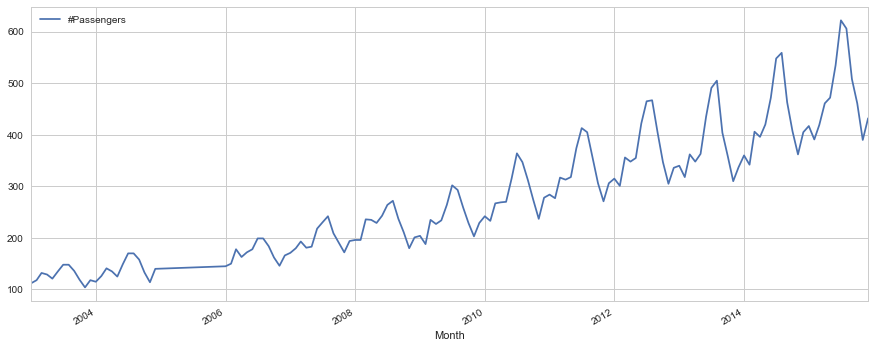

In [69]:
df.plot()

Perform Dickey-Fuller test and Check Stationarity of Series <br>
** Q2. Is the series Stationary? **

In [70]:
#Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


In [71]:
# Stationarity Check - Lets do a quick check on Stationarity with Dickey Fuller Test 
# Convert the DF to series first
ts = df['#Passengers']
test_stationarity(ts)


Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


# Make Time Series Stationary

** Q3. After making the Series stationary. Does it passes the Dickey Fuller Test? **

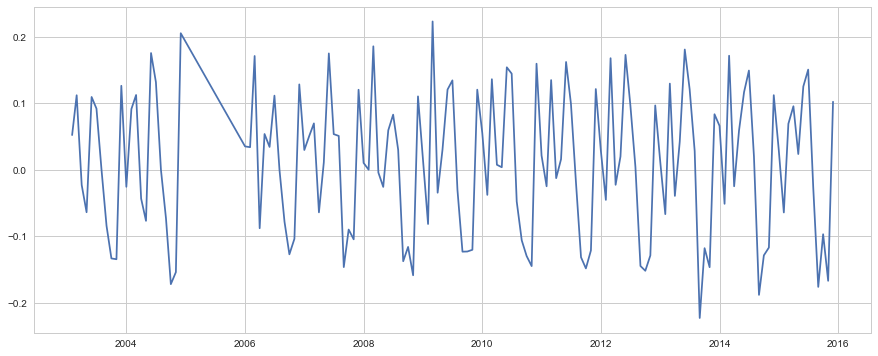

In [72]:
# There is a significant positive trend. We can apply transformation which penalize higher values more than smaller values
# These can be taking a log, cube root, etc. We take  a log transform
ts_log = np.log(ts)
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

In [73]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


# Forecast Time Series

Lets Use the ARIMA model <br>
** Q4. What is the RSS error value for ARIMA model after transformation?**

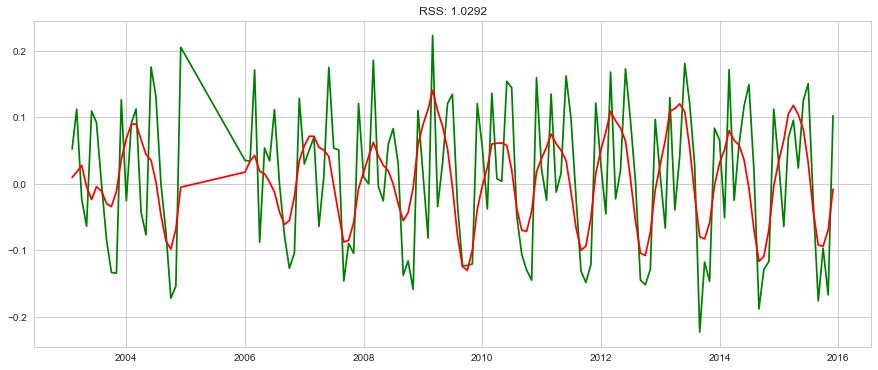

In [74]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff, color='green')
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

### Getting the data back to original scale

In [75]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head(20) )

Month
2003-02-01    0.009580
2003-03-01    0.017491
2003-04-01    0.027670
2003-05-01   -0.004521
2003-06-01   -0.023890
2003-07-01   -0.004347
2003-08-01   -0.010978
2003-09-01   -0.029929
2003-10-01   -0.034467
2003-11-01   -0.011279
2003-12-01    0.037212
2004-01-01    0.068135
2004-02-01    0.089434
2004-03-01    0.090030
2004-04-01    0.066152
2004-05-01    0.044054
2004-06-01    0.035467
2004-07-01    0.003100
2004-08-01   -0.047127
2004-09-01   -0.086353
dtype: float64


In [76]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head(20) )

Month
2003-02-01    0.009580
2003-03-01    0.027071
2003-04-01    0.054742
2003-05-01    0.050221
2003-06-01    0.026331
2003-07-01    0.021984
2003-08-01    0.011007
2003-09-01   -0.018922
2003-10-01   -0.053390
2003-11-01   -0.064668
2003-12-01   -0.027456
2004-01-01    0.040679
2004-02-01    0.130114
2004-03-01    0.220143
2004-04-01    0.286295
2004-05-01    0.330349
2004-06-01    0.365816
2004-07-01    0.368917
2004-08-01    0.321789
2004-09-01    0.235436
dtype: float64


In [77]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
2003-01-01    4.718499
2003-02-01    4.728079
2003-03-01    4.745570
2003-04-01    4.773241
2003-05-01    4.768720
dtype: float64

** Q5. What is the RSS error value for ARIMA model at original scale? **

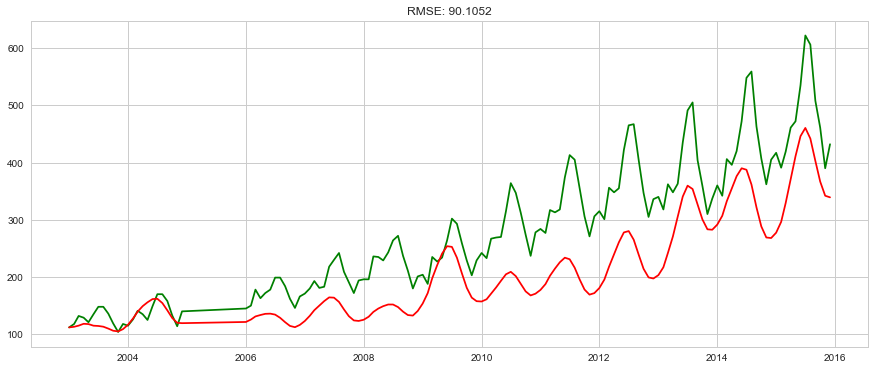

In [78]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts, color='green')
plt.plot(predictions_ARIMA,color='red')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

This a forecast at the original scale

# End